In [1]:
import torch

# Create simple tensors
x = torch.tensor([1, 2, 3, 4])
y = torch.tensor([10, 20, 30, 40])

# Elementwise operations
print("x + y =", x + y)
print("x * y=", x * y)
print("Shape of x:", x.shape)

x + y = tensor([11, 22, 33, 44])
x * y= tensor([ 10,  40,  90, 160])
Shape of x: torch.Size([4])


In [2]:
# 2D tensor (matrix)
a = torch.rand(2,3)
print(a)

# Access an element
print("Element [0,1] =", a[0,1].item())

tensor([[0.7744, 0.5941, 0.9145],
        [0.1285, 0.9872, 0.2053]])
Element [0,1] = 0.5941382646560669


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

x = torch.rand(1000,1000)
x = x.to(device)
print("Tensor moved to:", x.device)

Running on: cpu
Tensor moved to: cpu


In [4]:
x = torch.tensor(2.0, requires_grad=True)
y = x ** 3 + 2 * x + 1 # function of x
# Compute derivative dy/dx
y.backward()
print("dy/dx =", x.grad.item())

dy/dx = 14.0


In [5]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 2) # Input: 3 features → Output: 2 neurons

    def forward(self, x):
        return self.fc1(x)

# Create model instance
net = SimpleNN()
print(net)

# Run a forward pass
sample = torch.rand(1, 3)
output = net(sample)
print("Input:", sample)
print("Output:", output)

SimpleNN(
  (fc1): Linear(in_features=3, out_features=2, bias=True)
)
Input: tensor([[0.8215, 0.2718, 0.2101]])
Output: tensor([[0.1275, 0.1818]], grad_fn=<AddmmBackward0>)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

100%|██████████| 170M/170M [00:01<00:00, 102MB/s] 


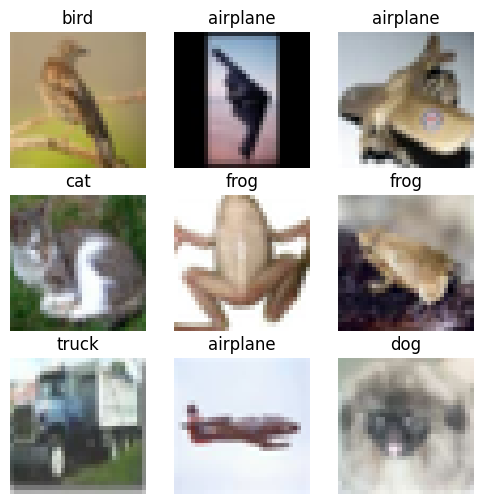

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                           download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
# Display sample images
dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].permute(1, 2, 0) * 0.5 + 0.5).numpy())
    # (C,H,W) → (H,W,C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In [8]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

ann = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)
# defines how the model updates its weights

In [9]:
for epoch in range(5):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad() #Clears out old gradients from the previous step
        outputs = ann(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() #Uses the gradients to update the model’s weights
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

Epoch 1, Loss: 1.6382
Epoch 2, Loss: 1.4360
Epoch 3, Loss: 1.3232
Epoch 4, Loss: 1.2343
Epoch 5, Loss: 1.1592


In [10]:
correct, total = 0, 0
# Turns off gradient tracking (no need to calculate gradients during testing)
with torch.no_grad():
    for images, labels in testloader:
        outputs = ann(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"ANN Test Accuracy: {100 * correct / total:.2f}%")

ANN Test Accuracy: 52.75%


In [11]:
# Evaluate Per-Class Accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for images, labels in testloader:
        outputs = ann(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
print("ANN Per-Class Accuracy:")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"{classname:10s} : {accuracy:.2f}%")

ANN Per-Class Accuracy:
airplane   : 68.70%
automobile : 60.70%
bird       : 34.20%
cat        : 30.60%
deer       : 48.10%
dog        : 49.80%
frog       : 59.20%
horse      : 57.40%
ship       : 63.30%
truck      : 55.50%


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #channels, number of filter or feature maps/kernel size/adds 1 pixel of zero-padding around the image edges
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [13]:
for epoch in range(10):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

Epoch 1, Loss: 1.3241
Epoch 2, Loss: 0.9543
Epoch 3, Loss: 0.7965
Epoch 4, Loss: 0.6794
Epoch 5, Loss: 0.5755
Epoch 6, Loss: 0.4780
Epoch 7, Loss: 0.3840
Epoch 8, Loss: 0.3036
Epoch 9, Loss: 0.2339
Epoch 10, Loss: 0.1751


In [14]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"CNN Test Accuracy: {100 * correct / total:.2f}%")

CNN Test Accuracy: 70.89%


In [15]:
# Evaluate per-class accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for images, labels in testloader:
        outputs = cnn(images) # or use cnn(images) for CNN
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
print("CNN Per-Class Accuracy:")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"{classname:10s} : {accuracy:.2f}%")

CNN Per-Class Accuracy:
airplane   : 82.10%
automobile : 82.50%
bird       : 63.60%
cat        : 58.40%
deer       : 60.90%
dog        : 59.70%
frog       : 67.90%
horse      : 71.70%
ship       : 82.50%
truck      : 79.60%
